In [6]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from PIL import Image



In [ ]:
bad_images = []
for subdir, _, files in os.walk("PetImages/"):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(subdir, file)
            try:
                img = Image.open(img_path)
                img.verify()  # Check if image is corrupted
            except:
                print('oops')
                bad_images.append(img_path)

print("Corrupted images found:", len(bad_images))
print(bad_images)

oops
oops


c:\Users\Mail Moolbaes\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted images found: 2


In [3]:
image_folder = "PetImages/"
img_size = (64, 64)
batch_size = 32

# Create a training dataset directly from the directory
# It will automatically infer class labels from the folder names
train_dataset = tf.keras.utils.image_dataset_from_directory(
    image_folder,
    validation_split=0.2,  # Use 20% of the images for validation
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Create a validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    image_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Get class names (e.g., ['Cat', 'Dog'])
class_names = train_dataset.class_names
print("Class names found:", class_names)

# Normalize the pixel values to be between 0 and 1
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.
Class names found: ['Cat', 'Dog']


Class Names: ['Cat', 'Dog']


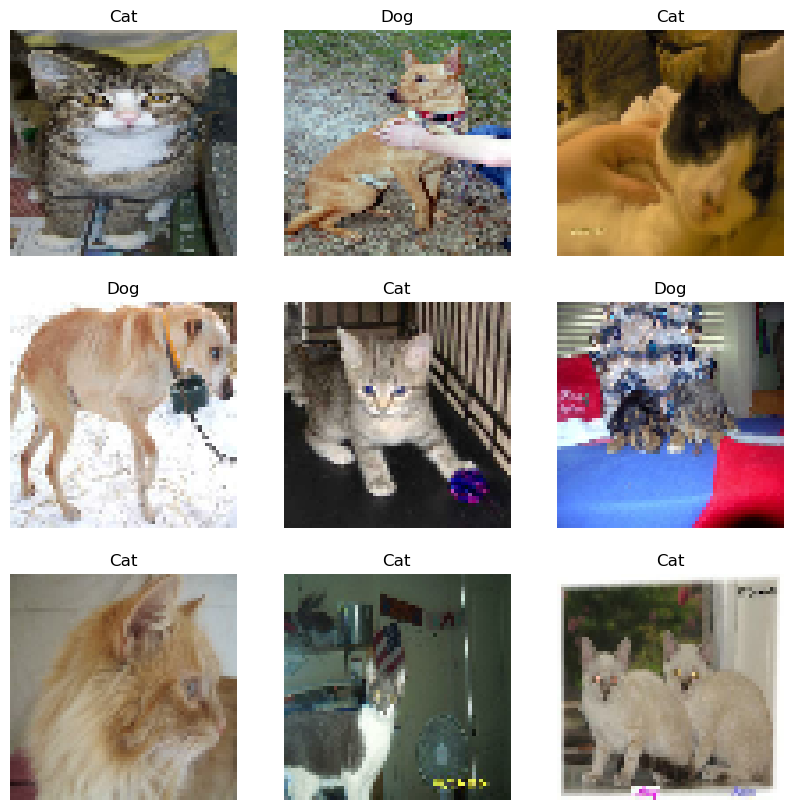

In [10]:
print("Class Names:", class_names)

plt.figure(figsize=(10, 10))

# Take one batch from the dataset
# A batch contains a tensor of images and a tensor of their corresponding labels
for images, labels in train_dataset.take(1):
  # `images` is a batch of images (e.g., 32 images of shape 64x64x3)
  # `labels` is a batch of labels (e.g., 32 integers from 0 to n_classes-1)
  
  # Loop through the first 9 images in the batch
  for i in range(9):
    # Create a subplot for each image
    ax = plt.subplot(3, 3, i + 1)
    
    # Display the image
    # Note: Keras reads images as tf.Tensor, matplotlib expects NumPy arrays.
    # We also expect pixel values to be in the range [0, 1] for floating point images.
    # If you haven't normalized yet, you'd do images[i].numpy().astype("uint8")
    plt.imshow(images[i].numpy().astype("float32"))
    
    # Get the corresponding label name from the class_names list
    label_name = class_names[labels[i]]
    plt.title(label_name)
    
    # Hide the axes
    plt.axis("off")

# Display the plot
plt.show()